In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from game.Bankgames import *
from game.plotting import *
from game.distributions import TruncatedGaussian, Uniform, PiecewiseUniform
import nashpy as nh
from tqdm import tqdm
from utils.project_dirs import *

In [46]:
def plot_mean_sd_over_time(dist_data, labels, title_prefix="Dist to NE"):
    """
    Plots the mean and standard deviation over time for multiple distance metrics.

    Parameters:
    - dist_data: dict {label -> pd.Series} where each series contains numpy arrays of shape (num_experiments, num_rounds)
    - labels: list of str, names for each metric (used in titles and legends)
    - title_prefix: str, prefix for the plot titles
    """
    num_metrics = len(dist_data)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(10, 5 * num_metrics), sharex=True)

    if num_metrics == 1:
        axes = [axes]  # Ensure it's iterable if only one plot

    for ax, (label, series) in zip(axes, dist_data.items()):

        data = np.array(series.tolist())     # Convert to numpy array (shape: num_experiments x num_rounds)
        # Compute mean and std deviation across experiments
        mean_dist = np.mean(data, axis=0)
        std_dist = np.std(data, axis=0)

        # Time steps
        rounds = np.arange(len(mean_dist))

        # Plot mean with shaded SD region
        ax.plot(rounds, mean_dist, label=f"{label} - Mean", linewidth=2)
        ax.fill_between(rounds, mean_dist - std_dist, mean_dist + std_dist, alpha=0.2, label=f"{label} ± 1 SD")

        # Labels and title
        ax.set_ylabel("L2 Distance")
        ax.set_title(f"{title_prefix} ({label})")
        ax.legend()
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel("Rounds")  # Only the last subplot gets the x-label
    plt.suptitle(title_prefix, fontsize=14)
    plt.tight_layout()
    plt.show()

In [2]:
# from itertools import product
# def search_eps_signs():
#     gamma_values = np.linspace(0.1, 1.0, 10)  # Choosing 5 values for gamma
# #     mu_values = np.linspace(0.1, 0.9, 5)  # Mu in [0,1]
# #     sigma_values = np.linspace(0.1, 0.9, 5)  # Sigma in [0,1]
#     mu_values = [0.1, 0.2, 0.6, 0.8, 0.9]
#     sigma_values = [0.2]

#     found_cases = {}

#     # Iterate over all possible combinations
#     for gamma_l, gamma_h, mu, sigma in product(gamma_values, gamma_values, mu_values, sigma_values):
#         if gamma_l >= gamma_h:  # Ensure gamma_l < gamma_h
#             continue
        
#         taus = sorted([1 / (2 + gamma) for gamma in [gamma_l, gamma_h]])
#         tg = TruncatedGaussian(mu=mu, sigma=sigma)
#         gtm = GameTrueMatrix2by2(gammas=[gamma_l, gamma_h], taus=taus, dist=tg)
        
#         eps1, eps2 = gtm.eps1, gtm.eps2
#         sign_pair = (np.sign(eps1), np.sign(eps2))

#         # Store unique cases for each sign combination
#         if sign_pair not in found_cases:
#             found_cases[sign_pair] = (gamma_l, gamma_h, mu, sigma, eps1, eps2)

#         # Stop early if we found all sign cases
#         if len(found_cases) == 4:
#             break
    
#     # Print results
#     for sign_pair, values in found_cases.items():
#         gamma_l, gamma_h, mu, sigma, eps1, eps2 = values
#         print(f"Sign: {sign_pair}, γ_l: {gamma_l:.2f}, γ_h: {gamma_h:.2f}, μ: {mu:.2f}, σ: {sigma:.2f}, eps1: {eps1:.4f}, eps2: {eps2:.4f}")

# # Run the search
# search_eps_signs()

## Epsilon_1 > 0, Epsilon_2 >0

Single symmetric NE is that both banks have strategy (tau_l, gamma_h)

In [34]:
gammas = sorted([0.3, 0.9])
taus = sorted([1/(2+gamma) for gamma in gammas])
mu = 0.1
sigma = 0.2
tg = TruncatedGaussian(mu = mu, sigma = sigma)
gtm = GameTrueMatrix2by2(gammas=gammas, taus=taus, dist=tg)
print(gtm.eps1, gtm.eps2) # epsilon1 and epsilon2

0.009428856621794143 0.004197023639765393


In [35]:
display(len(gtm.NE_theory), gtm.NE_theory) # this is what theory gives us
display(len(gtm.NE_se), gtm.NE_se) 
# this is from running nashpy directly on the utility matrices, note in nashpy row players strat i.e. B2 appears first

1

[[[0, 1, 0, 0], [0, 1, 0, 0]]]

1

[(array([0., 1., 0., 0.]), array([0., 1., 0., 0.]))]

## Code below runs hedge on all 3 games
- with the known matrix
- with the fresh matrix
- with the moving average matrix

And initializes 5 different random probability vectors for both banks (seed set for reproducibility)

In [36]:
from game.run_game import run_across_initializations

In [37]:
# save directory for dataframe
instance_name = f'Tg_mu{mu}_sig{sigma}_gamma{str(gammas)}.pkl' # truncated gaussian
epsigns = 'sign++'
save_path = str(saved_df_2gamma(epsigns=epsigns) / instance_name)
print(save_path)

/Users/krishna/Documents/Research/BankGame/bankgame/notebooks/../saved_df/2_gamma/sign++/Tg_mu0.1_sig0.2_gamma[0.3, 0.9].pkl


In [53]:
T = 20000
eta = 0.1

df = run_across_initializations(gtm=gtm, save_dest=save_path, num_startprofiles=5, T=T, eta = eta)

100%|█████████████████████████████████████████████| 5/5 [00:58<00:00, 11.78s/it]


In [54]:
df #across 5 different random starting vectors for both banks

,Bank1_start,Bank2_start,eps1,eps2,Bank1iter_knownmat,Bank2iter_knownmat,closestNE_knownmat,closestNEdist_knownmat,closestNEdist_knownmat_b1,closestNEdist_knownmat_b2,...,closestNE_fresh1,closestNEdist_fresh1,closestNEdist_fresh1_b1,closestNEdist_fresh1_b2,Bank1iter_moving1,Bank2iter_moving1,closestNE_moving1,closestNEdist_moving1,closestNEdist_moving1_b1,closestNEdist_moving1_b2
0,"[0.04872488080912729, 0.24038477898068955, 0.4...","[0.021616249915949792, 0.029157006779427008, 0...",0.009429,0.004197,"[[0.04872488080912729, 0.24038477898068955, 0....","[[0.021616249915949792, 0.029157006779427008, ...","([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])",0.000482,"[0.9185583137488735, 0.9182970807033684, 0.918...","[1.2639752388700396, 1.2639463882880182, 1.263...",...,"([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])",0.000455,"[0.9185583137488735, 0.9185583137488735, 0.918...","[1.2639752388700396, 1.2639752388700396, 1.263...","[[0.04872488080912729, 0.24038477898068955, 0....","[[0.021616249915949792, 0.029157006779427008, ...","([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])",0.000604,"[0.9185583137488735, 0.9185583137488735, 0.918...","[1.2639752388700396, 1.2639752388700396, 1.263..."
1,"[0.30227189396461684, 0.005842499272261992, 0....","[0.06957095461260054, 0.5140203216059982, 0.28...",0.009429,0.004197,"[[0.30227189396461684, 0.005842499272261992, 0...","[[0.06957095461260054, 0.5140203216059982, 0.2...","([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])",0.001319,"[1.1485923766235815, 1.148593543067811, 1.1485...","[0.5823640384759611, 0.5821864968077516, 0.582...",...,"([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])",0.000803,"[1.1485923766235815, 1.1485923766235815, 1.148...","[0.5823640384759611, 0.5823640384759611, 0.582...","[[0.30227189396461684, 0.005842499272261992, 0...","[[0.06957095461260054, 0.5140203216059982, 0.2...","([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])",0.002097,"[1.1485923766235815, 1.1485939674782086, 1.148...","[0.5823640384759611, 0.582202933227656, 0.5820..."
2,"[0.13324051925174774, 0.04488414230775062, 0.3...","[0.7589438355121143, 0.10475580904610926, 0.10...",0.009429,0.004197,"[[0.13324051925174774, 0.04488414230775062, 0....","[[0.7589438355121143, 0.10475580904610926, 0.1...","([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])",0.000448,"[1.1336164710034524, 1.1336078734850297, 1.133...","[1.1788690231030465, 1.1785999022051148, 1.178...",...,"([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])",0.000418,"[1.1336164710034524, 1.1336164710034524, 1.133...","[1.1788690231030465, 1.1788690231030465, 1.178...","[[0.13324051925174774, 0.04488414230775062, 0....","[[0.7589438355121143, 0.10475580904610926, 0.1...","([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])",0.000587,"[1.1336164710034524, 1.133608506916869, 1.1336...","[1.1788690231030465, 1.1785991488704783, 1.178..."
3,"[0.3842500320901294, 0.02446829735360312, 0.35...","[0.27066977267313375, 0.442690655211345, 0.140...",0.009429,0.004197,"[[0.3842500320901294, 0.02446829735360312, 0.3...","[[0.27066977267313375, 0.442690655211345, 0.14...","([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])",0.000266,"[1.1314392377769045, 1.1314007626837983, 1.131...","[0.6518820745825383, 0.6516374342295079, 0.651...",...,"([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])",0.000323,"[1.1314392377769045, 1.1314392377769045, 1.131...","[0.6518820745825383, 0.6518820745825383, 0.651...","[[0.3842500320901294, 0.02446829735360312, 0.3...","[[0.27066977267313375, 0.442690655211345, 0.14...","([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])",0.000369,"[1.1314392377769045, 1.1314008523884098, 1.131...","[0.6518820745825383, 0.6516405073559407, 0.651..."
4,"[0.5166685377580662, 0.24408753190653998, 0.15...","[0.16783576522150734, 0.1161072798091265, 0.01...",0.009429,0.004197,"[[0.5166685377580662, 0.24408753190653998, 0.1...","[[0.16783576522150734, 0.1161072798091265, 0.0...","([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])",0.000188,"[0.932265360006527, 0.9318124725553469, 0.9313...","[1.1408265543093

In [55]:
df['closestNEdist_knownmat_b1']

0    [0.9185583137488735, 0.9182970807033684, 0.918...
1    [1.1485923766235815, 1.148593543067811, 1.1485...
2    [1.1336164710034524, 1.1336078734850297, 1.133...
3    [1.1314392377769045, 1.1314007626837983, 1.131...
4    [0.932265360006527, 0.9318124725553469, 0.9313...
Name: closestNEdist_knownmat_b1, dtype: object

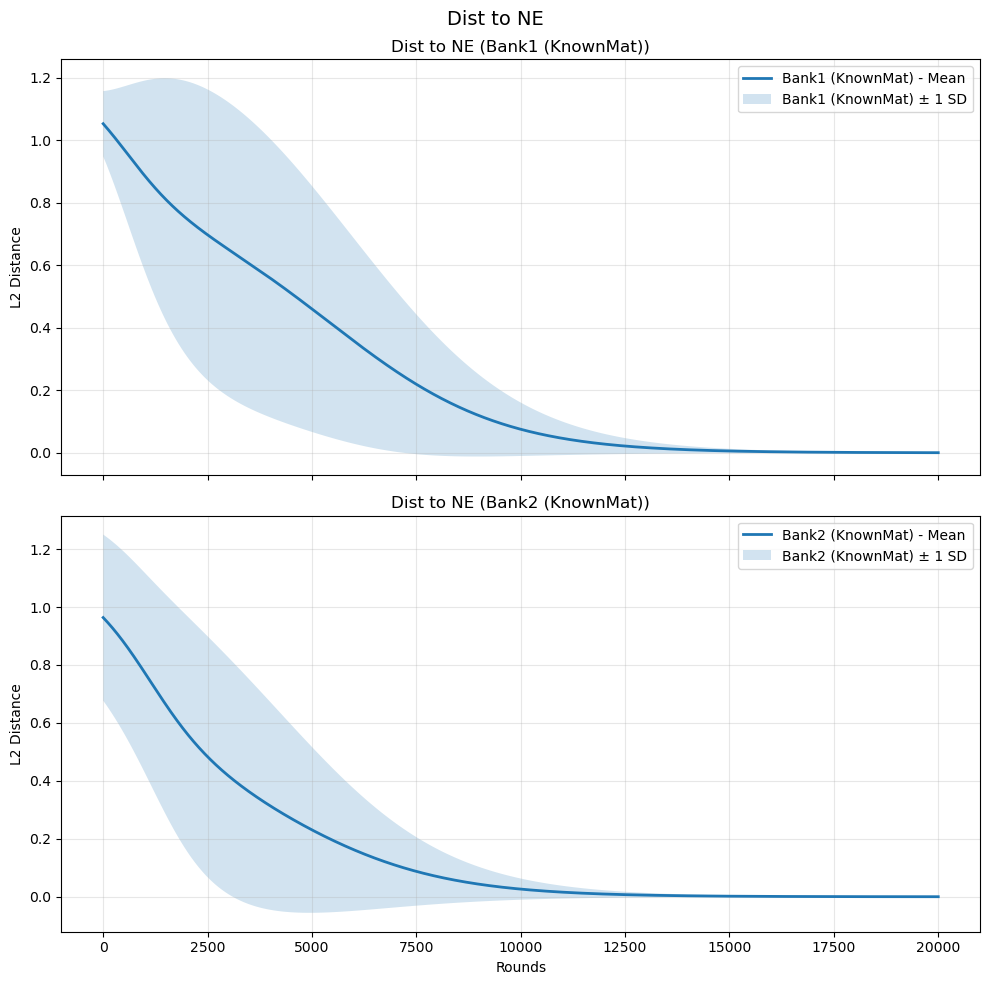

In [56]:
# Example Usage:
plot_mean_sd_over_time(
    {
        "Bank1 (KnownMat)": df['closestNEdist_knownmat_b1'],
        "Bank2 (KnownMat)": df['closestNEdist_knownmat_b2']
    },
    labels=["Bank1", "Bank2"]
)

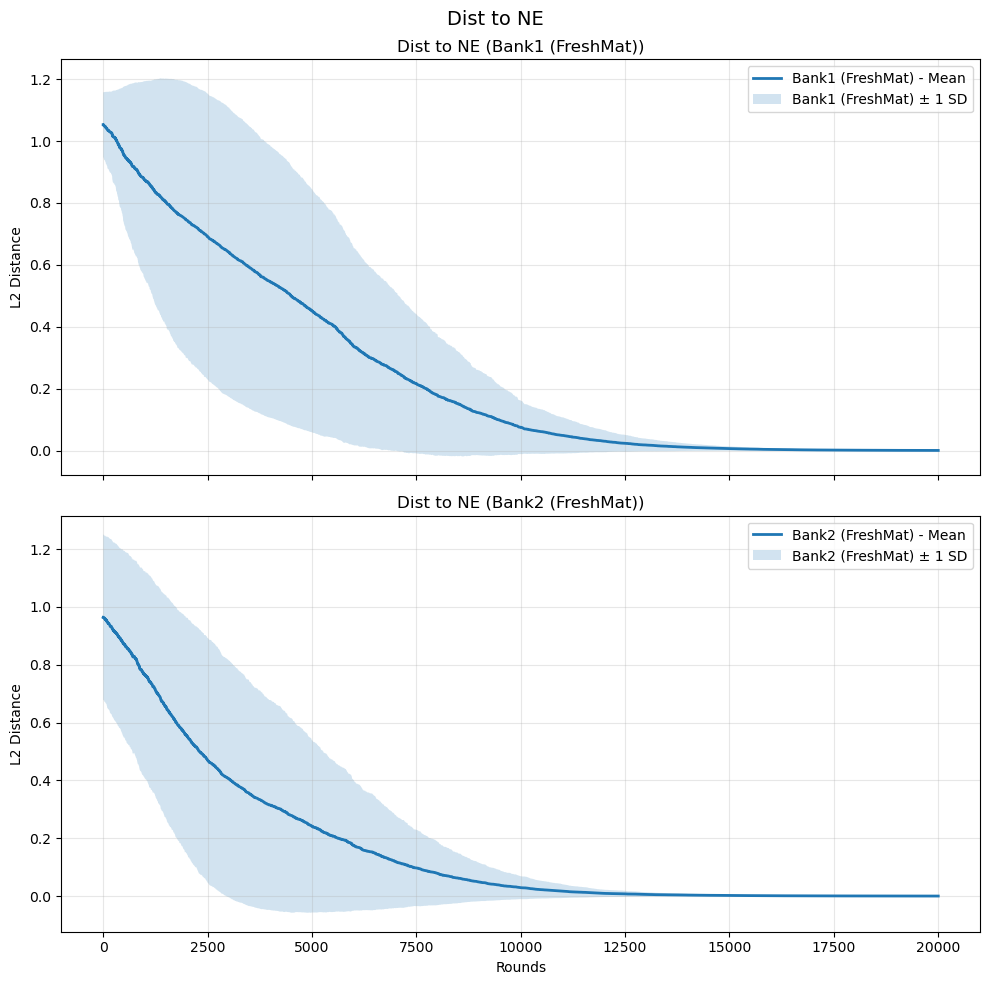

In [58]:
# Example Usage:
plot_mean_sd_over_time(
    {
        "Bank1 (FreshEst)": df['closestNEdist_fresh1_b1'],
        "Bank2 (FreshEst)": df['closestNEdist_fresh1_b2']
    },
    labels=["Bank1", "Bank2"]
)

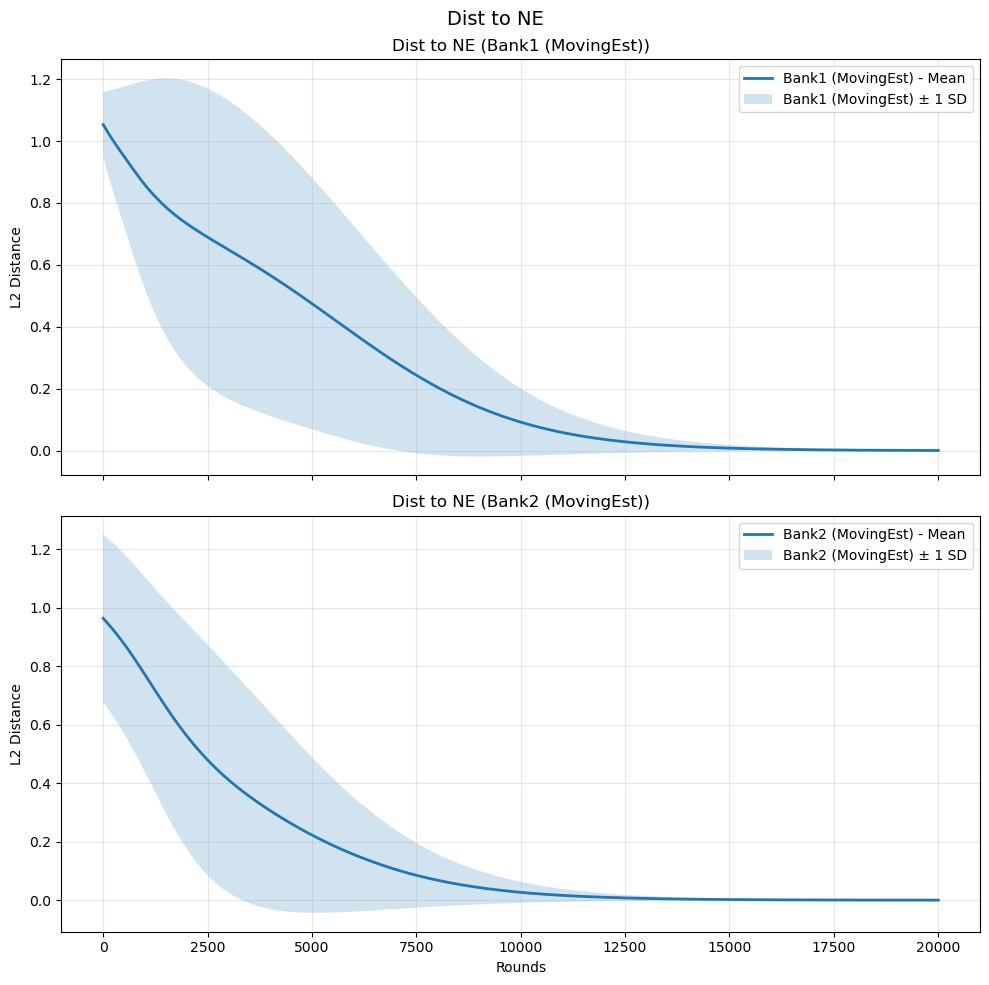

In [60]:
# Example Usage:
plot_mean_sd_over_time(
    {
        "Bank1 (MovingEst)": df['closestNEdist_moving1_b1'],
        "Bank2 (MovingEst)": df['closestNEdist_moving1_b2']
    },
    labels=["Bank1", "Bank2"]
)